In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

from flows import RealNVP, Planar
from models import NormalizingFlowModel

## Load and process the data

In [2]:
mode = 'ROC'

In [3]:
f_rnd = pd.read_hdf("/data/t3home000/spark/LHCOlympics/data/MassRatio_RandD.h5")
f_PureBkg = pd.read_hdf("/data/t3home000/spark/LHCOlympics/data/MassRatio_pureBkg.h5")

In [4]:
f_rnd.head()

,Mjj,Mj1,j1 tau21,j1 tau32,j1 tau43,j1 sqrt(tau^2_1)/tau^1_1,j1 n_trk,j1 pT1,j1 M_trim,j1 M_prun,...,j2 sqrt(tau^2_1)/tau^1_1,j2 n_trk,j2 pT1,j2 M_trim,j2 M_prun,j2 M_mmdt,j2 M_sdb1,j2 M_sdb2,j2 M_sdm1,isSignal
0,2577.571899,98.677270,0.528903,0.788281,0.904471,4.241889,136.0,1285.895950,18.881765,9.797733,...,1.895988,128.0,1282.286017,42.162664,18.466533,18.466533,31.845136,42.162664,0.000000,0.0
1,3807.507389,584.595432,0.345626,0.463461,0.865982,1.069972,320.0,1334.493332,556.665923,562.607897,...,1.377217,348.0,1306.137883,395.226881,393.309512,405.034096,405.034096,405.034096,405.034096,0.0
2,1710.965414,159.597526,0.677692,0.690707,0.695322,1.310040,332.0,678.557182,144.351550,142.366275,...,1.887494,236.0,1072.462085,54.235070,41.967840,41.352112,51.721630,70.442364,-0.000003,0.0
3,2603.379037,515.237299,0.091038,0.784454,0.860716,1.102743,248.0,1284.020224,501.564320,506.727622,...,1.997360,352.0,1217.031950,81.842001,60.307703,60.307703,72.423677,84.480859,0.000003,0.0
4,3294.162200,142.420213,0.507714,0.522686,0.904070,1.853319,220.0,1087.658980,129.146700,36.160229,...,1.113248,204.0,1205.343324,103.456059,99.817788,103.456059,103.456059,103.456059,0.000008,1.0


In [5]:
f_PureBkg.head()

,Mjj,Mj1,j1 tau21,j1 tau32,j1 tau43,j1 sqrt(tau^2_1)/tau^1_1,j1 n_trk,j1 pT1,j1 M_trim,j1 M_prun,...,j2 tau43,j2 sqrt(tau^2_1)/tau^1_1,j2 n_trk,j2 pT1,j2 M_trim,j2 M_prun,j2 M_mmdt,j2 M_sdb1,j2 M_sdb2,j2 M_sdm1
0,2308.313028,128.326132,0.189019,0.911555,0.849721,1.308323,144.0,697.776317,127.413126,127.413126,...,0.774201,2.003320,76.0,1405.544993,36.389206,30.116799,31.486846,31.486846,36.389206,-0.000011
1,2433.658374,168.702659,0.471191,0.668339,0.835098,2.122381,196.0,1218.344352,168.702659,99.211013,...,0.748061,1.591575,284.0,1181.231345,86.360518,78.302729,83.267629,87.636863,87.636863,-0.000003
2,2687.853262,259.775966,0.272282,0.834496,0.905154,2.443252,212.0,1278.656676,249.529914,27.569778,...,0.876479,2.694852,212.0,1370.333269,142.759911,17.207589,5.411157,161.894075,161.894075,0.000002
3,3020.510484,227.093270,0.681522,0.636388,0.861016,1.940825,384.0,999.484105,201.818360,47.193330,...,0.743863,1.343559,252.0,1526.551452,116.511073,109.874007,109.874007,109.874007,133.288161,-0.000005
4,2285.694841,118.372552,0.456816,0.713677,0.644830,1.873234,112.0,1391.822493,60.537433,59.034145,...,0.919837,1.776008,256.0,618.616945,86.433637,101.312752,113.277482,113.277482,113.277482,0.000001


In [6]:
if mode == 'ROC':
    dt_PureBkg = f_rnd.values
else:
    dt_PureBkg = dt_PureBkg = f_PureBkg.values

In [7]:
dt_PureBkg[:,1] = (dt_PureBkg[:,1]-np.mean(dt_PureBkg[:,1]))/np.std(dt_PureBkg[:,1])
dt_PureBkg[:,2] = (dt_PureBkg[:,2]-np.mean(dt_PureBkg[:,2]))/np.std(dt_PureBkg[:,2])
dt_PureBkg[:,3] = (dt_PureBkg[:,3]-np.mean(dt_PureBkg[:,3]))/np.std(dt_PureBkg[:,3])
dt_PureBkg[:,4] = (dt_PureBkg[:,4]-np.mean(dt_PureBkg[:,4]))/np.std(dt_PureBkg[:,4])
dt_PureBkg[:,5] = (dt_PureBkg[:,5]-np.mean(dt_PureBkg[:,5]))/np.std(dt_PureBkg[:,5])
dt_PureBkg[:,6] = (dt_PureBkg[:,6]-np.mean(dt_PureBkg[:,6]))/np.std(dt_PureBkg[:,6])


dt_PureBkg[:,8] = (dt_PureBkg[:,8]-np.mean(dt_PureBkg[:,8]))/np.std(dt_PureBkg[:,8])
dt_PureBkg[:,9] = (dt_PureBkg[:,9]-np.mean(dt_PureBkg[:,9]))/np.std(dt_PureBkg[:,9])
dt_PureBkg[:,10] = (dt_PureBkg[:,10]-np.mean(dt_PureBkg[:,10]))/np.std(dt_PureBkg[:,10])
dt_PureBkg[:,11] = (dt_PureBkg[:,11]-np.mean(dt_PureBkg[:,11]))/np.std(dt_PureBkg[:,11])
dt_PureBkg[:,12] = (dt_PureBkg[:,12]-np.mean(dt_PureBkg[:,12]))/np.std(dt_PureBkg[:,12])

dt_PureBkg[:,14] = (dt_PureBkg[:,14]-np.mean(dt_PureBkg[:,14]))/np.std(dt_PureBkg[:,14])
dt_PureBkg[:,15] = (dt_PureBkg[:,15]-np.mean(dt_PureBkg[:,15]))/np.std(dt_PureBkg[:,15])
dt_PureBkg[:,16] = (dt_PureBkg[:,16]-np.mean(dt_PureBkg[:,16]))/np.std(dt_PureBkg[:,16])
dt_PureBkg[:,17] = (dt_PureBkg[:,17]-np.mean(dt_PureBkg[:,17]))/np.std(dt_PureBkg[:,17])
dt_PureBkg[:,18] = (dt_PureBkg[:,18]-np.mean(dt_PureBkg[:,18]))/np.std(dt_PureBkg[:,18])
dt_PureBkg[:,19] = (dt_PureBkg[:,19]-np.mean(dt_PureBkg[:,19]))/np.std(dt_PureBkg[:,19])


dt_PureBkg[:,21] = (dt_PureBkg[:,21]-np.mean(dt_PureBkg[:,21]))/np.std(dt_PureBkg[:,21])
dt_PureBkg[:,22] = (dt_PureBkg[:,22]-np.mean(dt_PureBkg[:,22]))/np.std(dt_PureBkg[:,22])
dt_PureBkg[:,23] = (dt_PureBkg[:,23]-np.mean(dt_PureBkg[:,23]))/np.std(dt_PureBkg[:,23])
dt_PureBkg[:,24] = (dt_PureBkg[:,24]-np.mean(dt_PureBkg[:,24]))/np.std(dt_PureBkg[:,24])
dt_PureBkg[:,25] = (dt_PureBkg[:,25]-np.mean(dt_PureBkg[:,25]))/np.std(dt_PureBkg[:,25])

In [8]:
idx = dt_PureBkg[:,27]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]

In [9]:
total_PureBkg = torch.tensor(dt_PureBkg[bkg_idx])
total_PureBkg_train_x_1 = total_PureBkg.t()[1:7].t()
total_PureBkg_train_x_2 = total_PureBkg.t()[8:13].t()
total_PureBkg_train_x_3 = total_PureBkg.t()[14:20].t()
total_PureBkg_train_x_4 = total_PureBkg.t()[21:26].t()

total_PureBkg_selection = torch.cat((total_PureBkg_train_x_1,total_PureBkg_train_x_2,total_PureBkg_train_x_3,total_PureBkg_train_x_4),dim=1)
#total_PureBkg_selection = torch.cat((total_PureBkg_train_x_1,total_PureBkg_train_x_3),dim=1)

In [10]:
total_PureBkg_selection.shape

torch.Size([1000000, 22])

In [11]:
bs = 1000
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [12]:
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(22, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 48),
            nn.LeakyReLU(True),            
            nn.Linear(48, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 48),
            nn.LeakyReLU(True),
            nn.Linear(48, 96),
            nn.LeakyReLU(True),
            nn.Linear(96, 22),
            nn.Sigmoid()
        )
        
        flow_init = Planar(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [13]:
N_EPOCHS = 50
PRINT_INTERVAL = 2000
NUM_WORKERS = 4
LR = 1e-4

N_FLOWS = 3
Z_DIM = 3

n_steps = 0

In [14]:
model = VAE_NF(N_FLOWS, Z_DIM).cuda()

In [15]:
optimizer = optim.Adam(model.parameters(), lr=LR)

In [16]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss = loss_recons + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time)
            ))

        n_steps += 1

In [17]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss = loss_recons + kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [18]:
print(model)

VAE_NF(
  (encoder): Sequential(
    (0): Linear(in_features=22, out_features=96, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=96, out_features=48, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=48, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=48, out_features=96, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=96, out_features=22, bias=True)
    (5): Sigmoid()
  )
  (flows): NormalizingFlowModel(
    (flows): ModuleList(
      (0): Planar()
      (1): Planar()
      (2): Planar()
    )
  )
)


In [19]:
BEST_LOSS = 99999
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, N_EPOCHS):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        if mode == 'ROC':
            torch.save(model.state_dict(),"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var.h5")
        else:
            torch.save(model.state_dict(), "/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var.h5")
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 5:
            print("Patience Limit Reached")
            break 

Epoch 1:


/home/spark/miniconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation Completed (valid)!	Loss: -215.0943 Time: 3.763 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -298.8510 Time: 3.799 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -328.1637 Time: 3.823 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -354.3074 Time: 3.719 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -366.1111 Time: 3.741 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: -368.1232 Time: 3.735 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -369.2805 Time: 3.701 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: -370.4260 Time: 3.706 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -370.6817 Time: 3.746 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: -371.3973 Time: 3.736 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -372.4149 Time: 3.683 s
Saving model!
Epoch 12:

Evaluation Completed (valid)!	Loss: -374.4196 Time: 3.747 s
Saving model

In [21]:
model.load_state_dict(torch.load("/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var.h5"))

<All keys matched successfully>

## Testing with the trained model

In [ ]:
def get_mass_and_loss(inputstring):
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])


    
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    #total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_3),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]-
                       total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0], dt_in[:,10], dt_in[:,23], dt_in[:,9], dt_in[:,22], loss_total_in

In [ ]:
def get_mass(inputstring):

    f_in = pd.read_hdf(inputstring)
    dt_in = f_in.values
    
    return dt_in[:,0]

In [ ]:
bb2mass = get_mass("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass = get_mass("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [ ]:
bb2mass, bb2mmdt1, bb2mmdt2, bb2prun1,bb2prun2, bb2loss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_BB1.h5")
purebkgmass, purebkgmmdt1, purebkgmmdt2, purebkgprun1,purebkgprun2, purebkgloss = get_mass_and_loss("../../../2_lhc/LHC_Olympics2020/processing/test_dataset/MassRatio_pureBkg.h5")

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1100)
plt.hist(bb2loss,bins=bins,alpha=0.3,color='b',label='blackbox1')
plt.hist(purebkgloss,bins=bins,alpha=0.3,color='r',label='background')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
f = pd.read_hdf("Nsubjettiness_mjj.h5")
dt = f.values
idx = dt[:,15]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]
data_bkg = torch.tensor(dt[bkg_idx])
data_signal = torch.tensor(dt[signal_idx])
data_train_x_1 = data_bkg.t()[0:6].t()
data_train_x_2 = data_bkg.t()[7:13].t()
data_test_bkg = torch.cat((data_train_x_1,data_train_x_2),dim=1)
data_train_x_1 = data_signal.t()[0:6].t()
data_train_x_2 = data_signal.t()[7:13].t()
data_test_signal = torch.cat((data_train_x_1,data_train_x_2),dim=1)

In [ ]:
loss_bkg = torch.mean((model(data_test_bkg.float().cuda())[0]-data_test_bkg.float().cuda())**2,dim=1).data.cpu().numpy()


In [ ]:
loss_sig = torch.mean((model(data_test_signal.float().cuda())[0]-data_test_signal.float().cuda())**2,dim=1).data.cpu().numpy()


In [19]:
def get_loss(dt_in):

    #dt_in[:,1] = (dt_in[:,1]-np.mean(dt_in[:,1]))/np.std(dt_in[:,1])
    #dt_in[:,2] = (dt_in[:,2]-np.mean(dt_in[:,2]))/np.std(dt_in[:,2])
    #dt_in[:,3] = (dt_in[:,3]-np.mean(dt_in[:,3]))/np.std(dt_in[:,3])
    #dt_in[:,4] = (dt_in[:,4]-np.mean(dt_in[:,4]))/np.std(dt_in[:,4])
    #dt_in[:,5] = (dt_in[:,5]-np.mean(dt_in[:,5]))/np.std(dt_in[:,5])
    #dt_in[:,6] = (dt_in[:,6]-np.mean(dt_in[:,6]))/np.std(dt_in[:,6])

    #dt_in[:,8] = (dt_in[:,8]-np.mean(dt_in[:,8]))/np.std(dt_in[:,8])
    #dt_in[:,9] = (dt_in[:,9]-np.mean(dt_in[:,9]))/np.std(dt_in[:,9])
    #dt_in[:,10] = (dt_in[:,10]-np.mean(dt_in[:,10]))/np.std(dt_in[:,10])
    #dt_in[:,11] = (dt_in[:,11]-np.mean(dt_in[:,11]))/np.std(dt_in[:,11])
    #dt_in[:,12] = (dt_in[:,12]-np.mean(dt_in[:,12]))/np.std(dt_in[:,12])

    #dt_in[:,14] = (dt_in[:,14]-np.mean(dt_in[:,14]))/np.std(dt_in[:,14])
    #dt_in[:,15] = (dt_in[:,15]-np.mean(dt_in[:,15]))/np.std(dt_in[:,15])
    #dt_in[:,16] = (dt_in[:,16]-np.mean(dt_in[:,16]))/np.std(dt_in[:,16])
    #dt_in[:,17] = (dt_in[:,17]-np.mean(dt_in[:,17]))/np.std(dt_in[:,17])
    #dt_in[:,18] = (dt_in[:,18]-np.mean(dt_in[:,18]))/np.std(dt_in[:,18])
    #dt_in[:,19] = (dt_in[:,19]-np.mean(dt_in[:,19]))/np.std(dt_in[:,19])
    
    #dt_in[:,21] = (dt_in[:,21]-np.mean(dt_in[:,21]))/np.std(dt_in[:,21])
    #dt_in[:,22] = (dt_in[:,22]-np.mean(dt_in[:,22]))/np.std(dt_in[:,22])
    #dt_in[:,23] = (dt_in[:,23]-np.mean(dt_in[:,23]))/np.std(dt_in[:,23])
    #dt_in[:,24] = (dt_in[:,24]-np.mean(dt_in[:,24]))/np.std(dt_in[:,24])
    #dt_in[:,25] = (dt_in[:,25]-np.mean(dt_in[:,25]))/np.std(dt_in[:,25])   
    
    total_in = torch.tensor(dt_in)
    total_in_train_x_1 = total_in.t()[1:7].t()
    total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[14:20].t()
    total_in_train_x_4 = total_in.t()[21:26].t()
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    #total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_3),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss_total_in

In [ ]:
def get_loss(dt):
    
    #dt[:,0] = (dt[:,0]-np.mean(dt[:,0]))/np.std(dt[:,0])
    #dt[:,1] = (dt[:,1]-np.mean(dt[:,1]))/np.std(dt[:,1])
    #dt[:,2] = (dt[:,2]-np.mean(dt[:,2]))/np.std(dt[:,2])
    #dt[:,3] = (dt[:,3]-np.mean(dt[:,3]))/np.std(dt[:,3])
    #dt[:,4] = (dt[:,4]-np.mean(dt[:,4]))/np.std(dt[:,4])
    #dt[:,5] = (dt[:,5]-np.mean(dt[:,5]))/np.std(dt[:,5])

    #dt[:,7] = (dt[:,7]-np.mean(dt[:,7]))/np.std(dt[:,7])
    #dt[:,8] = (dt[:,8]-np.mean(dt[:,8]))/np.std(dt[:,8])
    #dt[:,9] = (dt[:,9]-np.mean(dt[:,9]))/np.std(dt[:,9])
    #dt[:,10] = (dt[:,10]-np.mean(dt[:,10]))/np.std(dt[:,10])
    #dt[:,11] = (dt[:,11]-np.mean(dt[:,11]))/np.std(dt[:,11])
    #dt[:,12] = (dt[:,12]-np.mean(dt[:,12]))/np.std(dt[:,12])

  
    
    total_in = torch.tensor(dt)
    total_in_train_x_1 = total_in.t()[0:6].t()
    #total_in_train_x_2 = total_in.t()[8:13].t()
    total_in_train_x_3 = total_in.t()[7:13].t()
    #total_in_train_x_4 = total_in.t()[21:26].t()
    #total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_2,total_in_train_x_3,total_in_train_x_4),dim=1)
    total_in_selection = torch.cat((total_in_train_x_1,total_in_train_x_3),dim=1)
    
    with torch.no_grad():
        loss_total_in = torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy()
    
    return loss_total_in

In [23]:
loss_bkg = get_loss(dt_PureBkg[bkg_idx])
loss_sig = get_loss(dt_PureBkg[signal_idx])

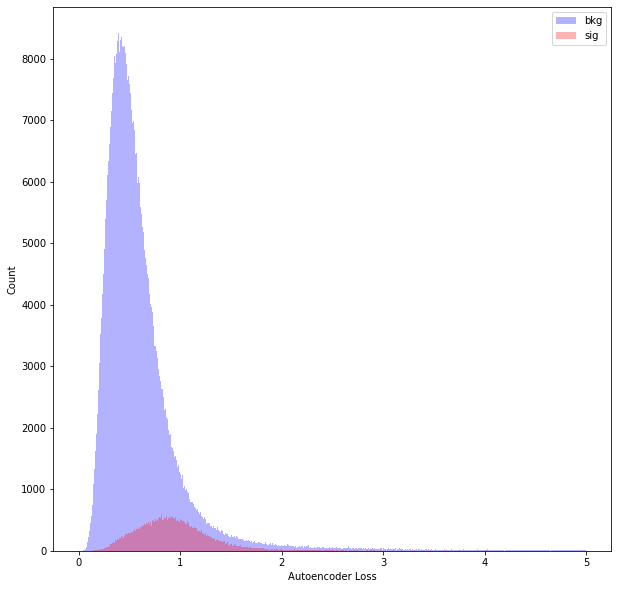

In [24]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [25]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [20]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)

Epoch 1:


/home/spark/miniconda3/envs/myenv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Evaluation Completed (valid)!	Loss: -198.0902 Time: 3.759 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -245.9733 Time: 3.761 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -261.9634 Time: 3.759 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -272.0471 Time: 3.689 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -281.1939 Time: 3.676 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: -280.5225 Time: 3.680 s
Not saving model! Last saved: 5
Epoch 7:

Evaluation Completed (valid)!	Loss: -282.6387 Time: 3.694 s
Saving model!
Epoch 8:

Evaluation Completed (valid)!	Loss: -282.3917 Time: 3.746 s
Not saving model! Last saved: 7
Epoch 9:

Evaluation Completed (valid)!	Loss: -280.5062 Time: 3.744 s
Not saving model! Last saved: 7
Epoch 10:

Evaluation Completed (valid)!	Loss: -280.7421 Time: 3.689 s
Not saving model! Last saved: 7
Epoch 11:

Evaluation Completed (valid)!	Loss: -277.1377 Time: 3.674 s
Not saving model! Last sa

Epoch 1:

Evaluation Completed (valid)!	Loss: -197.6224 Time: 3.686 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -253.0544 Time: 3.723 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -281.2064 Time: 3.711 s
Saving model!
Epoch 4:

Evaluation Completed (valid)!	Loss: -328.6892 Time: 3.726 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -338.9517 Time: 3.769 s
Saving model!
Epoch 6:

Evaluation Completed (valid)!	Loss: -343.3414 Time: 3.733 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -342.7094 Time: 3.745 s
Not saving model! Last saved: 6
Epoch 8:

Evaluation Completed (valid)!	Loss: -342.2816 Time: 3.739 s
Not saving model! Last saved: 6
Epoch 9:

Evaluation Completed (valid)!	Loss: -342.7515 Time: 3.737 s
Not saving model! Last saved: 6
Epoch 10:

Evaluation Completed (valid)!	Loss: -343.4157 Time: 3.756 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -340.5714 Time: 3.724 s
Not saving model! Last saved: 10
E


Evaluation Completed (valid)!	Loss: -347.1567 Time: 3.754 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -351.9708 Time: 3.745 s
Saving model!
Epoch 10:

Evaluation Completed (valid)!	Loss: -358.2091 Time: 3.770 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -361.0460 Time: 3.788 s
Saving model!
Epoch 12:

Evaluation Completed (valid)!	Loss: -366.0477 Time: 3.765 s
Saving model!
Epoch 13:

Evaluation Completed (valid)!	Loss: -369.7329 Time: 3.763 s
Saving model!
Epoch 14:

Evaluation Completed (valid)!	Loss: -372.6271 Time: 3.754 s
Saving model!
Epoch 15:

Evaluation Completed (valid)!	Loss: -372.3653 Time: 3.696 s
Not saving model! Last saved: 14
Epoch 16:

Evaluation Completed (valid)!	Loss: -370.3258 Time: 3.814 s
Not saving model! Last saved: 14
Epoch 17:

Evaluation Completed (valid)!	Loss: -366.0471 Time: 3.783 s
Not saving model! Last saved: 14
Epoch 18:

Evaluation Completed (valid)!	Loss: -359.8933 Time: 3.774 s
Not saving model! Last saved: 14



Evaluation Completed (valid)!	Loss: -349.6600 Time: 3.720 s
Saving model!
Epoch 13:

Evaluation Completed (valid)!	Loss: -352.2997 Time: 3.705 s
Saving model!
Epoch 14:

Evaluation Completed (valid)!	Loss: -356.2574 Time: 3.689 s
Saving model!
Epoch 15:

Evaluation Completed (valid)!	Loss: -361.2262 Time: 3.715 s
Saving model!
Epoch 16:

Evaluation Completed (valid)!	Loss: -363.7896 Time: 3.729 s
Saving model!
Epoch 17:

Evaluation Completed (valid)!	Loss: -366.8320 Time: 3.745 s
Saving model!
Epoch 18:

Evaluation Completed (valid)!	Loss: -370.7868 Time: 3.724 s
Saving model!
Epoch 19:

Evaluation Completed (valid)!	Loss: -372.0217 Time: 3.722 s
Saving model!
Epoch 20:

Evaluation Completed (valid)!	Loss: -372.8682 Time: 3.784 s
Saving model!
Epoch 21:

Evaluation Completed (valid)!	Loss: -372.4532 Time: 3.788 s
Not saving model! Last saved: 20
Epoch 22:

Evaluation Completed (valid)!	Loss: -369.6679 Time: 3.760 s
Not saving model! Last saved: 20
Epoch 23:

Evaluation Completed (vali


Evaluation Completed (valid)!	Loss: -360.5181 Time: 3.671 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -362.1343 Time: 3.674 s
Saving model!
Epoch 12:

Evaluation Completed (valid)!	Loss: -362.2449 Time: 3.674 s
Saving model!
Epoch 13:

Evaluation Completed (valid)!	Loss: -364.8044 Time: 3.694 s
Saving model!
Epoch 14:

Evaluation Completed (valid)!	Loss: -363.8733 Time: 3.718 s
Not saving model! Last saved: 13
Epoch 15:

Evaluation Completed (valid)!	Loss: -361.3981 Time: 3.693 s
Not saving model! Last saved: 13
Epoch 16:

Evaluation Completed (valid)!	Loss: -361.3889 Time: 3.710 s
Not saving model! Last saved: 13
Epoch 17:

Evaluation Completed (valid)!	Loss: -357.4744 Time: 3.723 s
Not saving model! Last saved: 13
Patience Limit Reached
Epoch 1:

Evaluation Completed (valid)!	Loss: -227.8003 Time: 3.711 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -303.8911 Time: 3.722 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -333.8804 Time: 3


Evaluation Completed (valid)!	Loss: -367.5369 Time: 3.671 s
Not saving model! Last saved: 8
Epoch 11:

Evaluation Completed (valid)!	Loss: -367.6053 Time: 3.803 s
Not saving model! Last saved: 8
Epoch 12:

Evaluation Completed (valid)!	Loss: -368.4680 Time: 3.671 s
Saving model!
Epoch 13:

Evaluation Completed (valid)!	Loss: -369.9087 Time: 3.671 s
Saving model!
Epoch 14:

Evaluation Completed (valid)!	Loss: -373.9876 Time: 3.665 s
Saving model!
Epoch 15:

Evaluation Completed (valid)!	Loss: -377.4295 Time: 3.673 s
Saving model!
Epoch 16:

Evaluation Completed (valid)!	Loss: -383.9802 Time: 3.679 s
Saving model!
Epoch 17:

Evaluation Completed (valid)!	Loss: -387.1912 Time: 3.699 s
Saving model!
Epoch 18:

Evaluation Completed (valid)!	Loss: -388.0860 Time: 3.699 s
Saving model!
Epoch 19:

Evaluation Completed (valid)!	Loss: -389.4752 Time: 3.701 s
Saving model!
Epoch 20:

Evaluation Completed (valid)!	Loss: -390.8955 Time: 3.698 s
Saving model!
Epoch 21:

Evaluation Completed (valid)